Here we will demonstrate how to generate dynamic responses to any arbitrary visual stimuli from a trained model

---

First, let's create a visual stimulus where we present 2 static images for 500 ms each. Before and after each image, we'll place blanks (gray screens).

In [1]:
# Let's load some example images from the upstream pipeline

import numpy as np
from foundation.virtual.bridge import pipe_stim

images = pipe_stim.StaticImage.Image & 'image_class="imagenet" and image_id in (0, 1)'
images

Connecting ewang@at-database.ad.bcm.edu:3306


image_class,image_id image id,image actual image
imagenet,0,=BLOB=
imagenet,1,=BLOB=


In [2]:
# ...and fetch those image arrays

images = images.fetch("image", order_by=images.primary_key)
images = np.stack(images, axis=0)
images.shape

(2, 144, 256)

In [3]:
# Let's create 5 frames and times for the images and blanks

# 5 frames -- (144 x 256)
frames = np.full([5, 144, 256], 128, dtype=np.uint8) 

# 1st frame at 0s, 2nd at 0.5s, 3rd at 1s, etc..
times = [0, 0.5, 1, 1.5, 2] 

# ...and let's insert our images into the 2nd and 4th frames
frames[1] = images[0]
frames[3] = images[1]

In [4]:
# Finally, let's create a video from those frames

from foundation.utils.video import Video

video = Video.fromarray(frames, times=times)

In [ ]:
# This will animate the video and display it in the jupyter notebook

video.animate()

---

Now that we have a video to present a model, let's load up an example model. For this demonstration, we will use `{'network_id': '650e0507177f51934eae82f8c8730374', 'model_id': 'b067a83e1e851c4433cbfb512e58a7bb'}`

In [5]:
# This is the key for that example model

key = {
    'network_id': '650e0507177f51934eae82f8c8730374',
    'model_id': 'b067a83e1e851c4433cbfb512e58a7bb'
}

In [6]:
# This is the corresponding row in the `Network` link table...

from foundation.fnn.network import Network

Network & key

network_id neural network,network_type network type,network_ts automatic timestamp
650e0507177f51934eae82f8c8730374,VisualNetwork,2023-07-17 19:32:24


In [7]:
# ...and the `Model` link table

from foundation.fnn.model import Model

Model & key

model_id neural network model,model_type model type,model_ts automatic timestamp
b067a83e1e851c4433cbfb512e58a7bb,Instance,2023-07-21 08:14:13


In [8]:
# This is how to get the data identifier for this network

data_id = (Network & key).link.data_id
data_id

'02ca654b280828eca0241247f4e7e9f0'

In [9]:
# That is used to restrict the `Data` link table

from foundation.fnn.data import Data

data = Data & {"data_id": data_id}
data

data_id network data,data_type data type,data_ts automatic timestamp
02ca654b280828eca0241247f4e7e9f0,VisualScan,2023-06-15 15:17:45


In [10]:
# From that data link, we can get the sampling period (in seconds)

period = data.link.compute.sampling_period
period

0.03333333333333333

In [11]:
# ...and response offset (in seconds)

offset = data.link.compute.unit_offset
offset

0.0

In [12]:
# ...and stimulus resolution (in pixels)

height, width = data.link.compute.resolution
height, width

(144, 256)

In [13]:
# ...and resizing method identifier

resize_id = data.link.compute.resize_id
resize_id

'9b07f7038587b888bc1312559f48d163'

In [14]:
# We'll use that identifier to load the resizing method

from foundation.utility.resize import Resize

resize = Resize & {"resize_id": resize_id}
resize

resize_id resizing method,resize_type resize type,resize_ts automatic timestamp
9b07f7038587b888bc1312559f48d163,PilResize,2023-05-26 11:34:07


In [15]:
# And we'll resize our video to the appropriate height and width for our model

rvideo = resize.link.resize(video=video, height=height, width=width)

In [16]:
# This is how to load the trained model using cuda (GPU)

from foundation.fnn.model import NetworkModel
from foundation.utils import use_cuda

with use_cuda():
    net = (NetworkModel & key).model

In [17]:
# With the resized video, let's create a stimulus generator

stimuli = rvideo.generate(period=period)

In [18]:
# And we'll feed that to our model, collecting responses in a list

responses = []

for r in net.generate_response(stimuli=stimuli):
    
    responses.append(r)

Video Frames: 100% 61/61 [00:01<00:00, 40.30it/s]


In [19]:
# Let's stack those responses in a 2D matrix

responses = np.stack(responses, axis=0)
responses.shape

(61, 8509)

In [20]:
# This is the shape of our matrix

frames, units = responses.shape

In [21]:
# Since we have the number of frames, the sampling period and offset, 
# we know the timing of the response

response_times = np.arange(frames) * period + offset

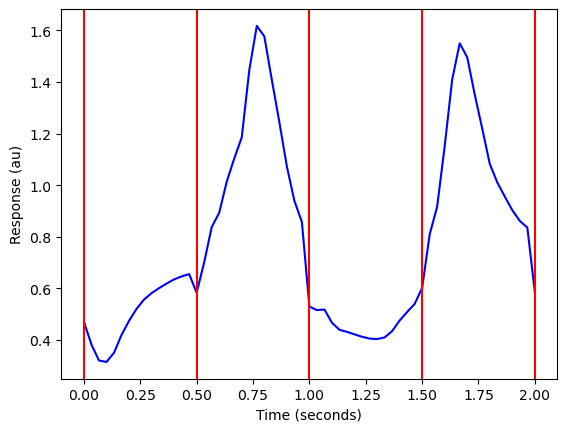

In [22]:
# Let's plot the response for one of the units

from matplotlib import pyplot as plt

# Let's select and plot the first unit
unit_repsonse = responses[:, 0]
plt.plot(response_times, unit_repsonse, c='blue')

# We'll also plot the onset times of each of stimulus frames
for stim_time in video.times:
    plt.axvline(stim_time, c='red')
    
plt.xlabel("Time (seconds)")
plt.ylabel("Response (au)")
plt.show()